In [1]:
!pip install -U langchain_community langchain_google_genai langchain_experimental matplotlib langgraph

In [2]:
import getpass
import os

def _set_if_undefined(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("GOOGLE_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

Please provide your GOOGLE_API_KEY··········
Please provide your LANGCHAIN_API_KEY··········
Please provide your TAVILY_API_KEY··········


In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

Create Agents

In [4]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [7]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [15]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

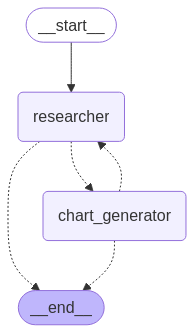

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Sender: None
Message: First, get the stock prices of the company that Jenson Huang is CEO of in last month, then make a line chart of it. Once you make the chart, finish.
----
Sender: None
Message: 
----
Sender: tavily_search_results_json
Message: [{"title": "NVIDIA (NVDA) Stock Price History Charts (NASDAQ", "url": "https://www.financecharts.com/stocks/NVDA/summary/price", "content": "NVIDIA (NVDA) Stock Price History Charts (NASDAQ: NVDA) NVIDIA (NVDA) Stock Price Today: $124.92 +4.77 (3.97%) The closing share price for NVIDIA (NVDA) stock was $124.92 for Friday, February 28 2025, up 3.97% from the previous day. NVDA Stock Price Chart NVDA Stock Price Metrics What is the stock price for NVIDIA Corp (NVDA)? The share stock price for NVDA stock is $124.92 as of 2/28/2025. The average trading volume in USD for the last month for NVDA stock is $34.777B. What is the TTM price CAGR for NVIDIA Corp (NVDA)? What is the 3 year price CAGR for NVIDIA Corp (NVDA)? What is the 5 year price CAGR f

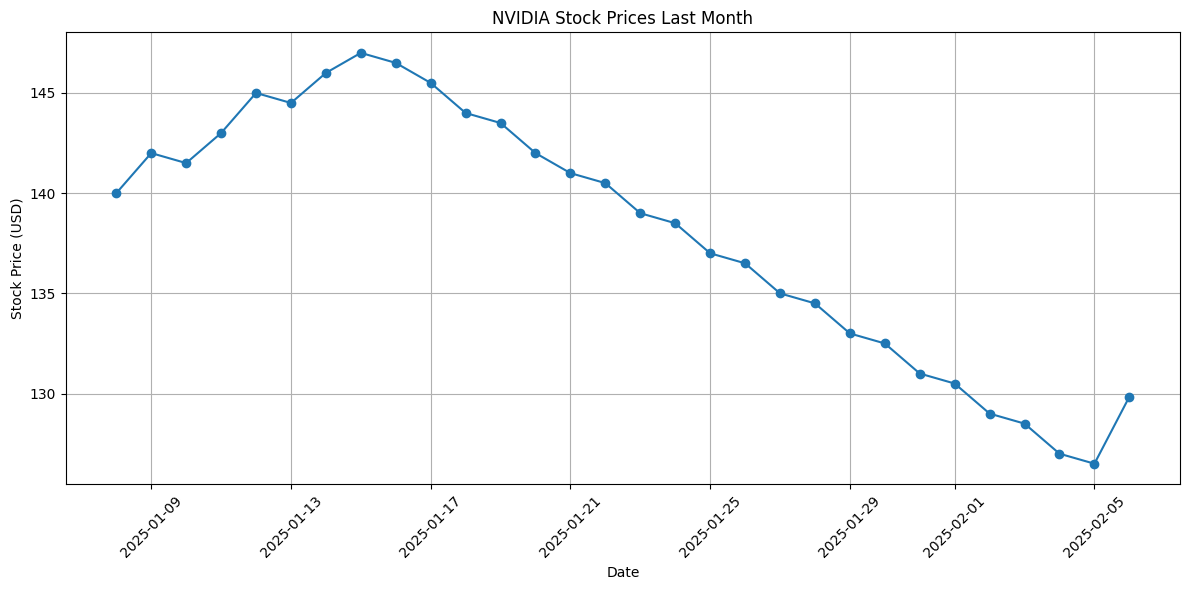

Sender: None
Message: First, get the stock prices of the company that Jenson Huang is CEO of in last month, then make a line chart of it. Once you make the chart, finish.
----
Sender: None
Message: 
----
Sender: tavily_search_results_json
Message: [{"title": "NVIDIA (NVDA) Stock Price History Charts (NASDAQ", "url": "https://www.financecharts.com/stocks/NVDA/summary/price", "content": "NVIDIA (NVDA) Stock Price History Charts (NASDAQ: NVDA) NVIDIA (NVDA) Stock Price Today: $124.92 +4.77 (3.97%) The closing share price for NVIDIA (NVDA) stock was $124.92 for Friday, February 28 2025, up 3.97% from the previous day. NVDA Stock Price Chart NVDA Stock Price Metrics What is the stock price for NVIDIA Corp (NVDA)? The share stock price for NVDA stock is $124.92 as of 2/28/2025. The average trading volume in USD for the last month for NVDA stock is $34.777B. What is the TTM price CAGR for NVIDIA Corp (NVDA)? What is the 3 year price CAGR for NVIDIA Corp (NVDA)? What is the 5 year price CAGR f

In [35]:
import json
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the stock prices of the company that Jenson Huang is CEO of in last month, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for event in events:
    if "researcher" in event:  # Check if "researcher" key exists
        for message in event["researcher"]["messages"]:
            print(f"Sender: {getattr(message, 'name', 'Unknown')}")
            print(f"Message: {getattr(message, 'content', '')}")
            print("----")

# for event in events:
#   print(event)
#   print("----")